In [21]:
# %%
import matplotlib.pyplot as plt
from ANN_models import PredictionModel
import os 
import json
import torch
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
import sys
import matplotlib as mpl
# Default settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")
os.chdir(sys.path[0])

# %%
def t_test(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1)
    std2 = np.std(group2)
    nobs1 = len(group1)
    nobs2 = len(group2)
    
    modified_std1 = np.sqrt(np.float32(nobs1)/
                    np.float32(nobs1-1)) * std1
    modified_std2 = np.sqrt(np.float32(nobs2)/
                    np.float32(nobs2-1)) * std2
    
    statistic, pvalue = stats.ttest_ind_from_stats( 
            mean1=mean1, std1=modified_std1, nobs1=nobs1,   
            mean2=mean2, std2=modified_std2, nobs2=nobs2)

    return statistic, pvalue

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# %%
# mus_types = ['low', 'high', 'medium']
mus_types = ['low']
# mua_types = ['all', 'low', 'high', 'medium']
mua_types = ['all']
# ijv_depth = ['+1mm', '+0.5mm', '-0.5mm', '-1mm', 'standard']
ijv_depth = ['standard']
ijv_size = ['-50%', '-30%', '-20%', '-10%', 'standard']
# ijv_size = ['-10%']
subject = 'ctchen'
result = 'surrogate_formula3'

C:\Users\dicky1031\AppData\Local\Temp\ipykernel_17532\3321481478.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [22]:
def plot_predict(result_folder, true_SO2, predict_SO2, RMSE, mean, std, max_error):
    plt.title(f'RMSE : {RMSE:.2f}%')
    plt.plot(true_SO2, predict_SO2, 'r.', markersize=5, label= 'predict')
    plt.plot(true_SO2, true_SO2,'b', label = 'optimal')
    plt.title(f"based on SO2=70% \nmean error:{mean:.2f}% std:{std:.2f}% \nmax error:{max_error:.2f}% RMSE:{RMSE:.2f}%")
    plt.xlabel("truth $\u0394$SO2(%)")
    plt.ylabel("predict $\u0394$SO2(%)")
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
            fancybox=True, shadow=True)
    plt.savefig(os.path.join("pic", subject, result, result_folder, f"plot_predict.png"), dpi=300, format='png', bbox_inches='tight')
    plt.close()
#     plt.show()

In [23]:
def cal_R_square(y_true, y_pred):
    y_bar = np.mean(y_true)
    numerator = np.sum(np.square(y_true-y_pred))
    denominator = np.sum(np.square(y_true-y_bar))
    R_square = 1 - numerator/denominator
    
    return R_square

In [24]:
def plot_R_square(result_folder, true_SO2, predict_SO2, RMSE, R_square):
    plt.title(f'RMSE : {RMSE:.2f}%')
    plt.plot(true_SO2, predict_SO2, 'r.', markersize=5, label= 'predict')
    plt.plot(true_SO2, true_SO2,'b', label = 'optimal')
    plt.title(f"based on SO2=70% \n RMSE:{RMSE:.2f}% $R^{2}$:{R_square:.3f}")
    plt.xlabel("truth $\u0394$SO2(%)")
    plt.ylabel("predict $\u0394$SO2(%)")
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
            fancybox=True, shadow=True)
    plt.savefig(os.path.join("pic", subject, result, result_folder, f"plot_predict_R_square.png"), dpi=300, format='png', bbox_inches='tight')
    plt.close()
#     plt.show()

In [25]:
def plot_all_hist(result_folder, error, mean, std):
    n,bin, pack = plt.hist(error)
    plt.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
    plt.text(mean+2*std, max(n), f'{mean+2*std:.2f}%')
    plt.text(mean-2*std, max(n), f'{mean-2*std:.2f}%')
    plt.xlabel('error(prediction-true)(%)')
    plt.ylabel('count')
    plt.title('error histogram')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
            fancybox=True, shadow=True)
    plt.savefig(os.path.join("pic", subject, result, result_folder, f"hist.png"), dpi=300, format='png', bbox_inches='tight')
    plt.close()
#     plt.show()


In [26]:
def plot_each_SO2(result_folder, test_result):
    predict_SO2 = test_result['output_ijv_SO2'].to_numpy()
    true_SO2 = test_result['target_ijv_SO2'].to_numpy()
    error = test_result['error_ijv_SO2'].to_numpy()
    RMSE = np.sqrt(np.mean(np.square(error)))
    mean = np.mean(error)
    std = np.std(error)
    max_error = np.max(error)
    # test_result['target_ijv_SO2'].unique()
    predict_SO2_table = {}
    true_SO2_table = {}
    error_table = {}
    for using_SO2 in test_result['target_ijv_SO2'].unique():
        each_SO2_test_result = test_result[test_result['target_ijv_SO2'] == using_SO2]
        
        predict_SO2 = each_SO2_test_result['output_ijv_SO2'].to_numpy()
        true_SO2 = each_SO2_test_result['target_ijv_SO2'].to_numpy()
        error = each_SO2_test_result['error_ijv_SO2'].to_numpy()
        predict_SO2_table[using_SO2] = predict_SO2
        true_SO2_table[using_SO2] = true_SO2
        error_table[using_SO2] = error
        
        n,bin, pack = plt.hist(error)
        plt.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
        plt.text(mean+2*std, max(n), f'{mean+2*std:.2f}%')
        plt.text(mean-2*std, max(n), f'{mean-2*std:.2f}%')
        plt.xlabel('error(prediction-true)(%)')
        plt.ylabel('count')
        plt.title(f'$\Delta$SO2={using_SO2:.2f}% error histogram')
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
                fancybox=True, shadow=True)
        plt.savefig(os.path.join("pic", subject, result, result_folder, f"{using_SO2:.2f}%_hist.png"), dpi=300, format='png', bbox_inches='tight')
        plt.close()
    #     plt.show()

    RMSE_set = []
    for using_SO2 in test_result['target_ijv_SO2'].unique():
        each_SO2_RMSE = np.sqrt(np.mean(np.square(error_table[using_SO2])))
        RMSE_set.append(each_SO2_RMSE)

    plt.title("RMSE of each $\Delta$SO2")
    plt.xlabel("truth $\u0394$SO2(%)")
    plt.ylabel("RMSE (%)")
    plt.plot(test_result['target_ijv_SO2'].unique(), RMSE_set)
    plt.savefig(os.path.join("pic", subject, result, result_folder, f"each_SO2_RMSE.png"), dpi=300, format='png', bbox_inches='tight')
    plt.close()
    #     plt.show()

In [ ]:
RMSE_set = []
for using_depth in ijv_depth:
    for using_size in ijv_size:
        for mus_type in mus_types:
            for mua_type in mua_types:
                result_folder = os.path.join(f'ijv_depth_{using_depth}', f'ijv_size_{using_size}', f"{mus_type}_scatter_prediction_input", f"{mua_type}_absorption")
                # %%
                os.makedirs(os.path.join("pic", subject, result, result_folder), exist_ok=True)
                test_result = pd.read_csv(os.path.join("model_test", subject, result, result_folder, "test.csv"))
                
                predict_SO2 = test_result['output_ijv_SO2'].to_numpy()
                true_SO2 = test_result['target_ijv_SO2'].to_numpy()
                error = test_result['error_ijv_SO2'].to_numpy()
                RMSE = np.sqrt(np.mean(np.square(error)))
                mean = np.mean(error)
                std = np.std(error)
                max_error = np.max(error)
                R_square = cal_R_square(y_true=true_SO2, y_pred=predict_SO2)
                plot_predict(result_folder, true_SO2, predict_SO2, RMSE, mean, std, max_error)
                plot_R_square(result_folder, true_SO2, predict_SO2, RMSE, R_square)
                plot_all_hist(result_folder, error, mean, std)
                plot_each_SO2(result_folder, test_result)
                
                RMSE_set += [RMSE]

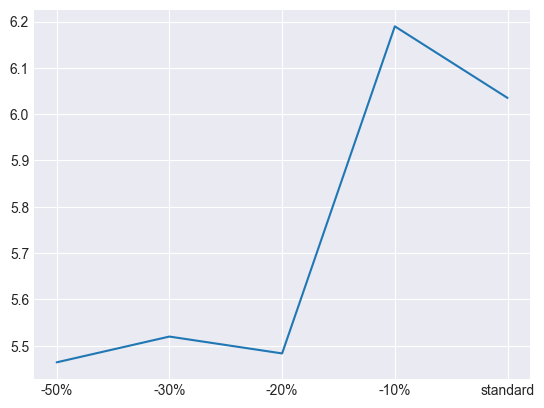

In [33]:
# plt.plot(RMSE_set)
# plt.xticks([i for i in range(5)], ['-50%', '-30%', '-20%', '-10%', 'standard'])
# plt.show()